In [2]:
import numpy as np
import torch
import torch.nn.functional as F

import datasets, diffusers, torchvision

from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm


device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Diffusion Pipeline
- Diffusion Modeling is like sculpting. You remove the noise, and get your scrulptor. 
- You remove noise, iteratively

1. Model     - which predicts noise to be removed
2. Scheduler - adds/removes noise to the image iteratively

In [3]:
image_generation_pipeline = diffusers.DDPMPipeline.from_pretrained(pretrained_model_name_or_path = "google/ddpm-celebahq-256", )
image_generation_pipeline.to(device);

# Create new scheduler and set num inference steps
scheduler = diffusers.DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")

diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


In [ ]:
images = image_generation_pipeline( num_inference_steps = 30 ).images
images[0]

# num_inference_steps = time_steps

In [ ]:
# Default number of inference steps = 1000
images = image_generation_pipeline().images
images[0]

In [ ]:
image_generation_pipeline

### Internals of Diffusion Pipeline

0it [00:00, ?it/s]

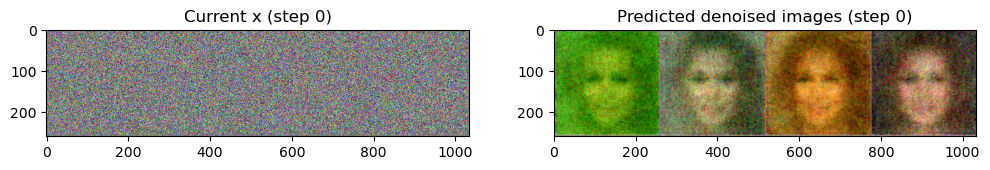

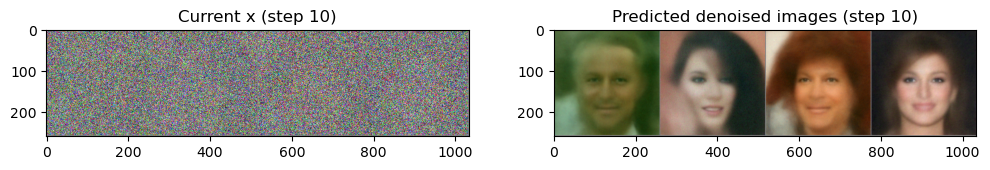

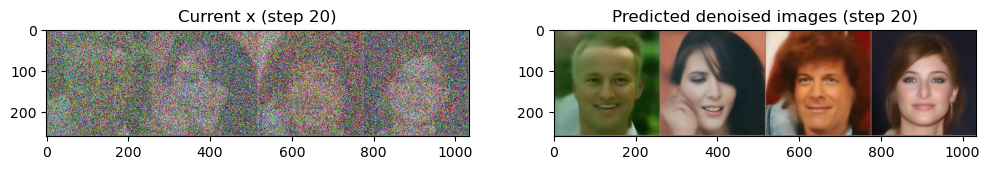

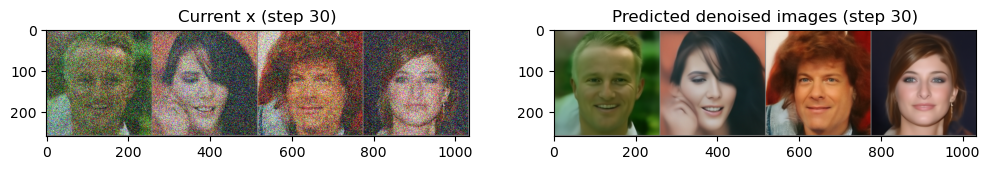

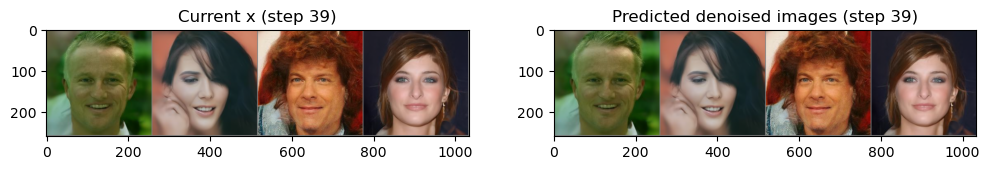

In [9]:
def diffusion_pipeline_through_timesteps(image_generation_pipeline, scheduler):
    # RANDOM NOISE IMAGE.
    # CLEAN IMAGE TO BE SCRUPTED BY REMOVING NOISE PREDICTION
    x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

    # Loop through the sampling timesteps
    for i, t in tqdm(enumerate(scheduler.timesteps)):

        # Prepare model input
        model_input = scheduler.scale_model_input(x, t)

        # Get the prediction
        with torch.no_grad():
            noise_pred = image_generation_pipeline.unet(model_input, t)["sample"]
        
        # Calculate what the updated sample should look like with the scheduler
        scheduler_output = scheduler.step(noise_pred, t, x)
        denoised_pred    = ( scheduler_output.pred_original_sample)

        # Update x
        x = scheduler_output.prev_sample

        # Occasionally display both x and the predicted denoised images
        if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))
            # plotting 'x'
            grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
            axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[0].set_title(f"Current x (step {i})")

            # plotting 'pred_x0'
            grid = torchvision.utils.make_grid(denoised_pred, nrow=4).permute(1, 2, 0)
            axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[1].set_title(f"Predicted denoised images (step {i})")
            plt.show()

diffusion_pipeline_through_timesteps(image_generation_pipeline, scheduler)